# Visualization and Exploration of the heat demand in one of Berlins districts 

We are going to use data of Berlins district *Steglitz-Zehlendorf*.
You find the dataset here:

https://www.govdata.de/web/guest/daten/-/details/energieverbrauch-der-offentlichen-gebaude-2017-bezirk-steglitz-zehlendorf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

In [2]:
url_to_inputfile = "https://www.berlin.de/ba-steglitz-zehlendorf/service/daten/ba-sz-energieverbrauchsuebersicht-2017-2021.csv"

We will use utf-8 as encoding, even though the input file seems to use different encoding. 
I could not figure out which enconding was used originally.

In [3]:
df_a = pd.read_csv(url_to_inputfile,
                   sep=';',
                   skiprows=2,
                   encoding='utf-8',
                   encoding_errors='ignore'
                  )

In [4]:
# Rename columns
rename_cols = {
    'Art der Wrme-versorgung': 'typ_of_heat_generation',  
    'Wrme-verbrauch witterungs-bereinigt [kWh]': 'heat_demand_2017 [kWh]',
    'Unnamed: 6': 'heat_demand_2018 [kWh]',
    'Unnamed: 7': 'heat_demand_2019 [kWh]',
    'Unnamed: 8': 'heat_demand_2020 [kWh]',
    'Unnamed: 9': 'heat_demand_2021 [kWh]'
}

columns_to_drop = [
    'Strom-verbrauch [kWh]', 
    'Unnamed: 11',
    'Unnamed: 12',
    'Unnamed: 13',
    'Unnamed: 14'
]

df_a = df_a \
    .copy() \
    .drop(columns_to_drop, axis=1) \
    .drop([0], axis=0) \
    .rename(columns=rename_cols)

### Let's have a look at the (almost raw) data-set before we clean and convert the values

In [5]:
df_a.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

,lfd. Nr.,Liegenschaft,Adresse,PLZ,typ_of_heat_generation,heat_demand_2017 [kWh],heat_demand_2018 [kWh],heat_demand_2019 [kWh],heat_demand_2020 [kWh],heat_demand_2021 [kWh],Bemerkungen
1,1,Helene-Lange-Gesamtschule - ehem. Frh. von Hnefeld-GS,Lauenburgerstr.114,12169.000000,Fernwrme,nan,nan,nan,nan,nan,Wrmeversorgung aus Nr. 20
2,2,Sachsenwald - Grundschule,Sachsenwaldstr. 20 - 21,12157.000000,Fernwrme,568.547,564.288,496.817,507.535,533.682,nan
3,3,Dunant- Grundschule,Gritznerstr.19 - 23,12163.000000,Fernwrme,855.007,834.156,761.302,750.191,786.260,Stromversorgung aus Nr. 31
4,4,Grundschule am Insulaner,Hanstedter Weg 11,12169.000000,Fernwrme,596.318,661.291,584.136,635.799,733.290,nan
5,5,Athene - Grundschule,Curtiusstr. 37 - 41,12205.000000,Fernwrme,684.009,685.169,688.484,626.388,701.965,versorgt mit Strom externe Kita
6,6,Alt Lankwitzer Grundschule,Schulstr.17-27,12247.000000,Gas,663.826,586.836,469.799,458.945,492.658,nan
7,7,Paul Schneider Grundschule,Seydlitzstr. 30 - 40,12249.000000,Gas,1.146.683,1.173.631,1.093.607,1.126.072,1.094.090,nan
8,8,Giesensdorfer - Grundschule,Ostpreuendamm 63,12207.000000,Gas,562.140,593.526,545.488,427.109,453.375,nan
9,9,Kronach - Grundschule,Moltkestr. 24-26,12203.000000,Gas,1.142.436,1.076.075,1.103.538,1.019.252,938.615,nan
10,10,Grundschule unter den Kastanien,Kastanienstrae 7,12209.000000,Gas,925.447,859.296,810.255,741.956,787.312,nan


### I'm convinced we can transorm this data-set into useful information
We can achieve that by curating the data into a form easier to understand.


In [6]:
# convert column names and format of values
convert_cols = ['heat_demand_2017 [kWh]', 'heat_demand_2018 [kWh]', 'heat_demand_2019 [kWh]', 
               'heat_demand_2020 [kWh]', 'heat_demand_2021 [kWh]']
annual_consumptions_cols = []

df_aa = df_a.copy()
for each_col in convert_cols:
    # remove decimal point '.'
    df_aa[each_col] = df_aa[each_col].apply(lambda x: float(str(x).replace('.','')))
    # convert from kWh to MWh and set correct unit in coloumn names
    new_col_name = each_col.replace('kWh', 'MWh')
    df_aa = df_aa.copy().rename(columns={each_col: new_col_name})
    annual_consumptions_cols.append(new_col_name)
    df_aa[new_col_name] = df_aa[new_col_name].apply(lambda x: x/1000).round()


In [7]:
# remove some information to focus on the annual heat demand of the properties from 2017 to 2021
df_b = df_aa.drop(['lfd. Nr.', 'Adresse', 'PLZ', 'typ_of_heat_generation', 'Bemerkungen'], axis=1)

In [8]:
# set min/max for bar-vizualisiation
max_val = df_b['heat_demand_2017 [MWh]'].quantile(.85)
min_val = 0

df_b.style\
    .bar(subset=annual_consumptions_cols,
         align='left', vmin=min_val, vmax=max_val, cmap="bwr",
         height=50, width=60, props="width: 80px; border-right: 1px solid black;")\
    .format(subset=annual_consumptions_cols, precision=0, na_rep='k.A.')

,Liegenschaft,heat_demand_2017 [MWh],heat_demand_2018 [MWh],heat_demand_2019 [MWh],heat_demand_2020 [MWh],heat_demand_2021 [MWh]
1,Helene-Lange-Gesamtschule - ehem. Frh. von Hnefeld-GS,k.A.,k.A.,k.A.,k.A.,k.A.
2,Sachsenwald - Grundschule,569,564,497,508,534
3,Dunant- Grundschule,855,834,761,750,786
4,Grundschule am Insulaner,596,661,584,636,733
5,Athene - Grundschule,684,685,688,626,702
6,Alt Lankwitzer Grundschule,664,587,470,459,493
7,Paul Schneider Grundschule,1147,1174,1094,1126,1094
8,Giesensdorfer - Grundschule,562,594,545,427,453
9,Kronach - Grundschule,1142,1076,1104,1019,939
10,Grundschule unter den Kastanien,925,859,810,742,787


## For exploring the heat consumption in a specific year a Bar Chart is usually a good start

In [9]:
register_matplotlib_converters()

sns.set_style(style='darkgrid', rc={'axes.facecolor': '.9', 'grid.color': '.8'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

/home/guest/.conda/envs/opendata/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/guest/.conda/envs/opendata/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/guest/.conda/envs/opendata/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='heat_demand_2017 [MWh]', ylabel='Liegenschaft'>

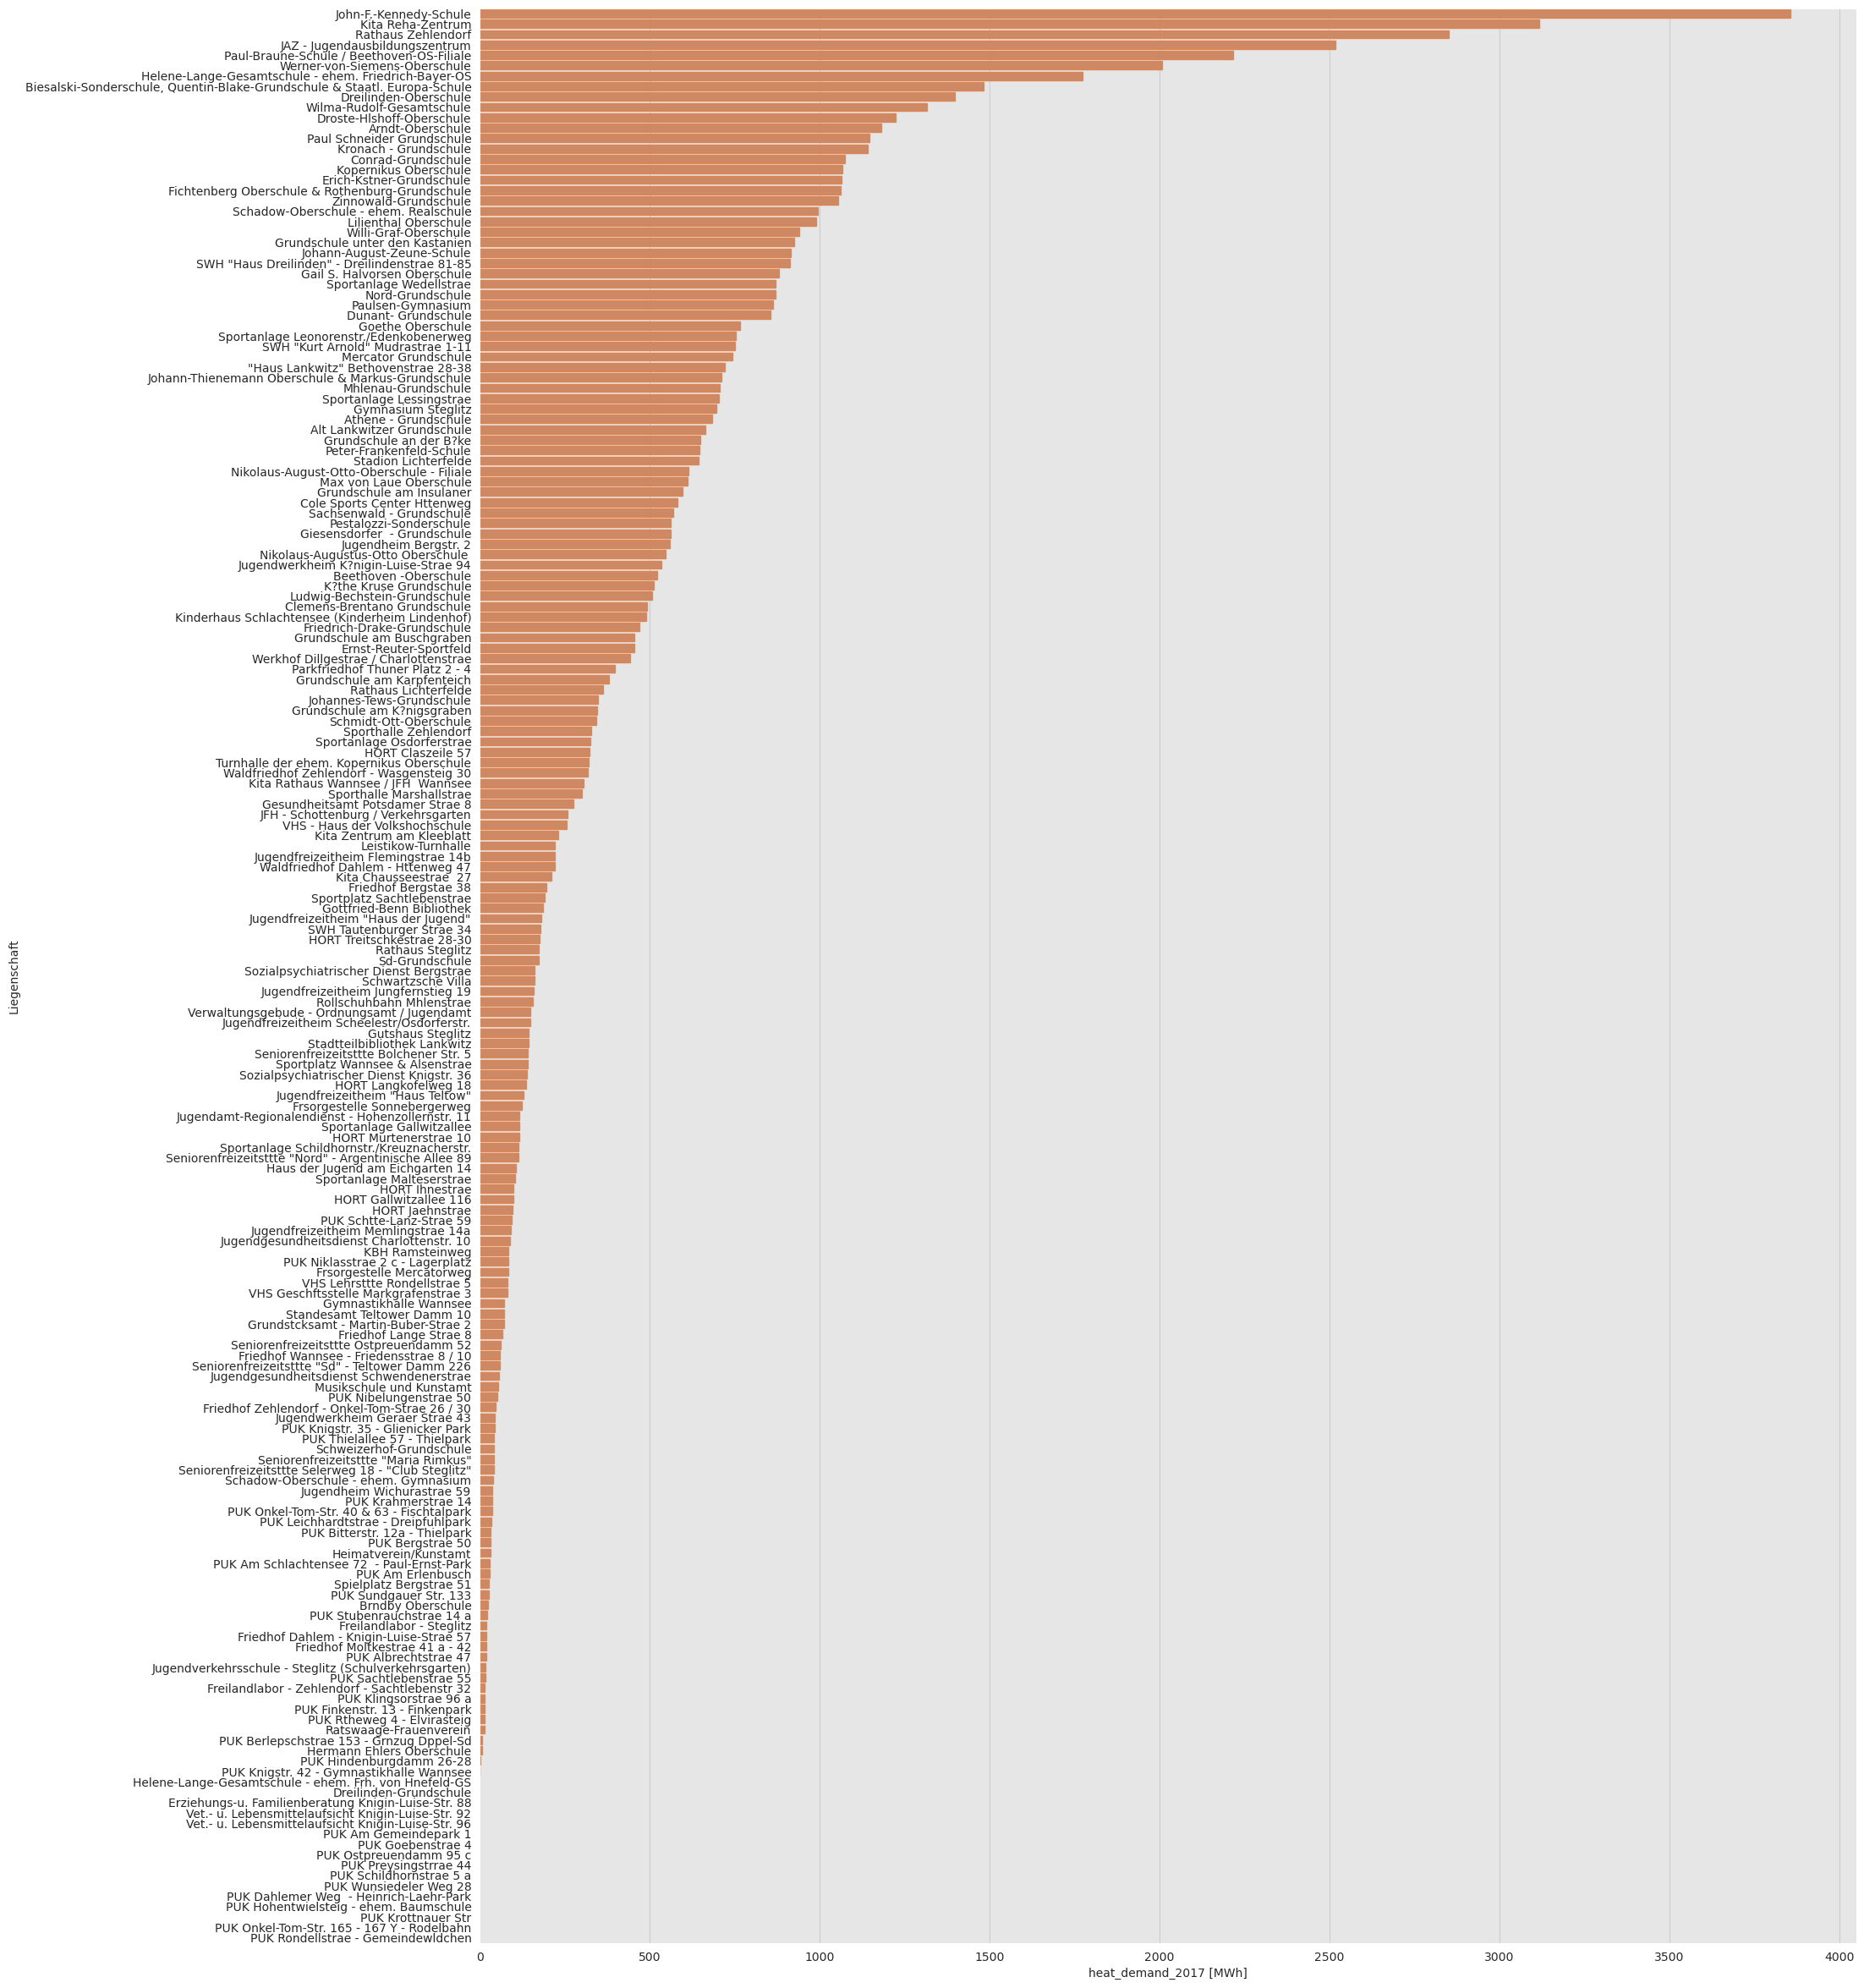

In [10]:
# remove summed heating demand of all properties for plotting
df_plot = df_b[:-1]


format_A4 = [21.0, 29.7]
fig, ax = plt.subplots(figsize=format_A4)

df_plot \
    .sort_values('heat_demand_2017 [MWh]', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='heat_demand_2017 [MWh]', 
        y='Liegenschaft',
        color=sns_c[1],
        edgecolor=sns_c[1],
        ax=ax,
        #width=1
    )